# House Prices - Advanced Regression Techniques
- David Atkins

### Data Prep

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(transform_output = 'pandas')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [4]:
def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

In [46]:
df = pd.read_csv('data/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [48]:
df['Id'].nunique()

1460

In [49]:
df = df.set_index('Id')
df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [50]:
df.duplicated().sum()

0

In [51]:
df.isna().sum()

MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [52]:
df['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [53]:
df['Fence'].value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [54]:
df['MiscFeature'].value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [55]:
df['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [56]:
df['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [57]:
cat_col = df.select_dtypes('object').columns
cat_col

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [58]:
ord_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
           'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
ord_col

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC']

In [101]:
ord_conv = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0}

In [106]:
df[ord_cols] = df[ord_cols].replace(ord_conv).astype('Float64')
df[ord_cols]

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,4.0,3.0,4.0,3.0,5.0,4.0,0.0,3.0,3.0,0.0
2,3.0,3.0,4.0,3.0,5.0,3.0,3.0,3.0,3.0,0.0
3,4.0,3.0,4.0,3.0,5.0,4.0,3.0,3.0,3.0,0.0
4,3.0,3.0,3.0,4.0,4.0,4.0,4.0,3.0,3.0,0.0
5,4.0,3.0,4.0,3.0,5.0,4.0,3.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1456,3.0,3.0,4.0,3.0,5.0,3.0,3.0,3.0,3.0,0.0
1457,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
1458,5.0,4.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0,0.0


,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond,PoolQC
Id,,,,,,,,,,
1,4.0,3.0,4.0,3.0,5.0,4.0,0.0,3.0,3.0,0.0
2,3.0,3.0,4.0,3.0,5.0,3.0,3.0,3.0,3.0,0.0
3,4.0,3.0,4.0,3.0,5.0,4.0,3.0,3.0,3.0,0.0
4,3.0,3.0,3.0,4.0,4.0,4.0,4.0,3.0,3.0,0.0
5,4.0,3.0,4.0,3.0,5.0,4.0,3.0,3.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1456,3.0,3.0,4.0,3.0,5.0,3.0,3.0,3.0,3.0,0.0
1457,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0
1458,5.0,4.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0,0.0


### Column Transformer

In [93]:
target = 'SalePrice'
y = df[target]
X = df.drop(columns=[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [107]:
# Categorical Pipeline
nom_cols = X_train.select_dtypes('object').columns
# Using value 'MISSING' for
impute_missing = SimpleImputer(strategy='constant',fill_value='MISSING')
nom_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
nom_pipe = make_pipeline(impute_missing, nom_encoder)
nom_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [108]:
# Numeric Pipeline
num_cols = X_train.select_dtypes('number').columns

mean_imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

num_pipe = make_pipeline(mean_imputer, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [109]:
#tuples
num_tuple = ('numeric', num_pipe, num_cols)
nom_tuple = ('categorical', nom_pipe, nom_cols)

In [110]:
#column transformer
preprocessor = ColumnTransformer([num_tuple, nom_tuple],
                                    verbose_feature_names_out=False)

In [113]:
X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)
X_train_tf.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_MISSING,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,GarageType_Detchd,GarageType_MISSING,GarageFinish_Fin,GarageFinish_MISSING,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_MISSING,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_MISSING,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,PoolQC_Ex,PoolQC_Fa,PoolQC_Gd,PoolQC_MISSING,Fence_GdPrv,Fence_GdWo,Fence_MISSING,Fence_MnPrv,Fence_MnWw,MiscFeature_Gar2,MiscFeature_MISSING,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1024,1.475911,-1.202174,-0.683950,0.637073,-0.515364,1.107889,1.020374,-0.521852,-0.944261,-0.284678,1.711873,0.642893,0.862092,-0.805280,-0.119821,-0.051643,-0.813995,-0.243017,0.772872,-0.766635,-1.112669,-0.207743,0.268177,0.591298,1.090030,0.293831,-0.192617,0.458853,-0.428838,-0.344584,-0.121808,-0.280154,-0.073333,-0.123489,-0.508139,0.137143,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
811,-0.871228,0.333763,-0.054883,-0.094926,0.390453,0.094543,0.682585,-0.025509,0.469362,2.166141,-1.279161,-0.046799,0.357895,-0.805280,-0.119821,-0.421692,1.119464,-0.243017,-1.062909,1.246471,0.128036,-0.207743,-0.963076,0.591298,-0.194518,0.293831,0.030695,1.295148,-0.718262,-0.344584,-0.121808,-0.280154,15.000378,-0.123489,-2.000860,-1.372124,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1385,-0.167086,-0.456147,-0.152524,-0.094926,-0.515364,-1.049557,-1.681937,-0.603603,-0.533502,-0.284678,-0.478553,-1.128667,-1.221922,0.465855,-0.119821,-0.518474,-0.813995,-0.243017,-1.062909,-0.766635,-1.112669,-0.207743,-0.347450,-0.961392,-1.644814,-1.069494,-0.938576,-0.738046,-0.718262,-0.344584,-0.121808,-0.280154,-0.073333,-0.123489,1.357763,0.891777,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
627,-0.871228,0.000000,0.144198,-0.826925,-0.515364,-0.363097,-0.330782,-0.603603,-0.979219,-0.284678,0.920261,-0.186540,0.650071,-0.805280,-0.119821,-0.207253,-0.813995,-0.243017,-1.062909,-0.766635,0.128036,-0.207743,-0.347450,0.591298,-0.774637,-1.069494,-0.910068,-0.738046,-0.718262,0.242811,-0.121808,-0.280154,-0.073333,1.704639,0.611402,-0.617490,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
814,-0.871228,0.202111,-0.090142,-0.094926,0.390453,-0.428474,-1.295893,0.815355,0.349193,-0.2

### Modeling

In [114]:
input_shape = X_train_tf.shape[1]
input_shape

300

In [116]:
def build_model1():
    model = Sequential()

    model.add(Dense(100, input_dim=input_shape, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    
    return model

model1 = build_model1()
model1.summary()

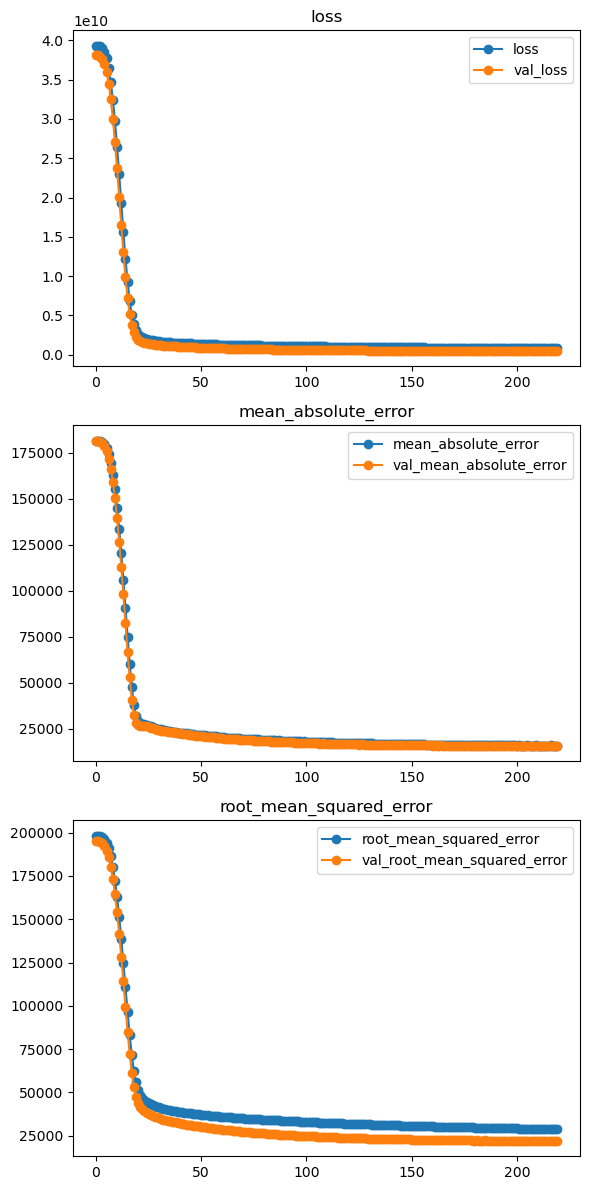

In [119]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history1 = model1.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=500,
                        verbose=0, callbacks = [early_stop])
plot_history(history1);

In [121]:
y_pred1 = model1.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred1))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred1)}')
print(f'final R2: {r2_score(y_test, y_pred1)}')

12/12 [==============================] - 0s 1ms/step
final RMSE: 29735.049343301183
final MAE: 18555.977375856164
final R2: 0.8737852744479133


- Attacking variance with a dropout layer

In [123]:
def build_model2():
    model = Sequential()

    model.add(Dense(100, input_dim=input_shape, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    
    return model
    
model2 = build_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               30100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,301
Trainable params: 40,301
Non-trainable params: 0
_________________________________________________________________


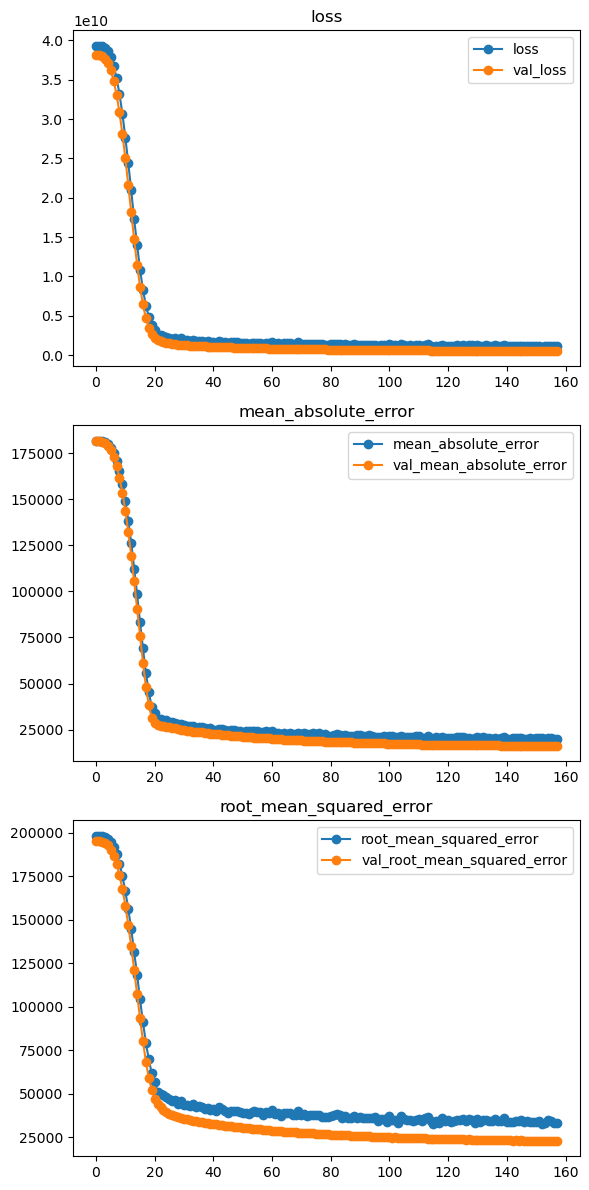

In [125]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history2 = model2.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=500,
                        verbose=0, callbacks = [early_stop])
plot_history(history2);

In [127]:
y_pred2 = model2.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred2))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred2)}')
print(f'final R2: {r2_score(y_test, y_pred2)}')

12/12 [==============================] - 0s 1ms/step
final RMSE: 30751.41320048911
final MAE: 18487.66022046233
final R2: 0.8650096081754695


- This reduced the R2 score. I am going to remove the dropout layer.
- I will also add an extra layer.

In [129]:
def build_model3():
    model = Sequential()

    model.add(Dense(100, input_dim=input_shape, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    
    return model
    
model3 = build_model3()
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               30100     
                                                                 
 dense_10 (Dense)            (None, 100)               10100     
                                                                 
 dense_11 (Dense)            (None, 100)               10100     
                                                                 
 dense_12 (Dense)            (None, 1)                 101       
                                                                 
Total params: 50,401
Trainable params: 50,401
Non-trainable params: 0
_________________________________________________________________


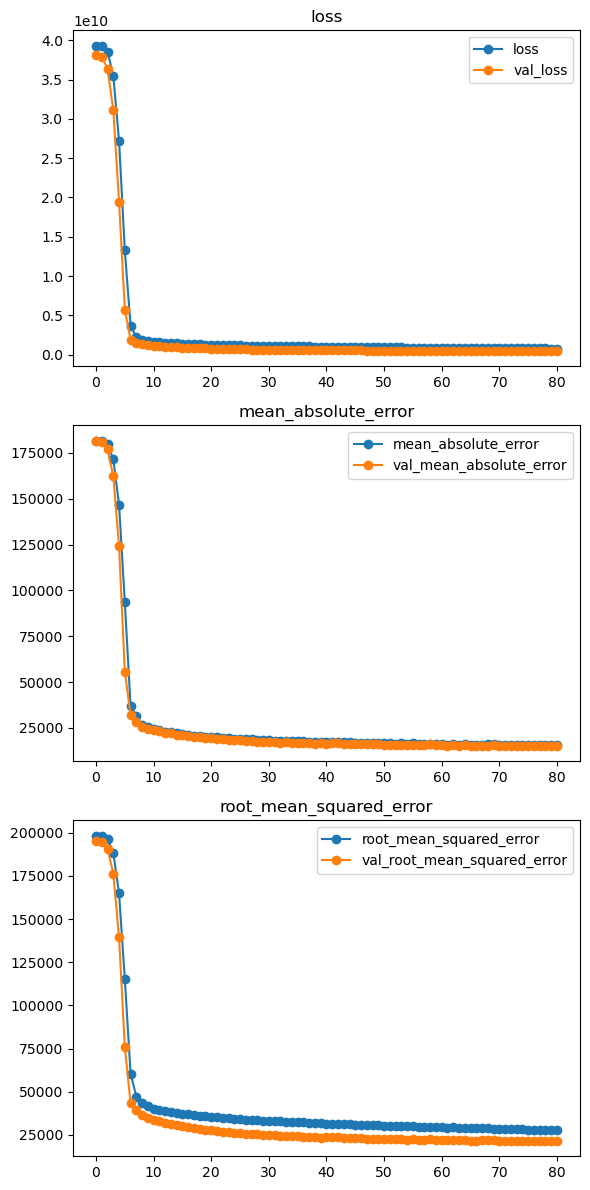

In [131]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history3 = model3.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=500,
                        verbose=0, callbacks = [early_stop])
plot_history(history3);

In [132]:
y_pred3 = model3.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred3))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred3)}')
print(f'final R2: {r2_score(y_test, y_pred3)}')

12/12 [==============================] - 0s 2ms/step
final RMSE: 29246.46428347101
final MAE: 18122.525053510275
final R2: 0.8778989382633002


- This slight increase from the original R2 suggests more layer may continue to help

In [134]:
def build_model4():
    model = Sequential()

    model.add(Dense(250, input_dim=input_shape, activation = 'relu'))
    model.add(Dense(250, activation = 'relu'))
    model.add(Dense(250, activation = 'relu'))
    model.add(Dense(250, activation = 'relu'))
    model.add(Dense(250, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    
    return model

model4 = build_model4()
model4.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 250)               75250     
                                                                 
 dense_17 (Dense)            (None, 250)               62750     
                                                                 
 dense_18 (Dense)            (None, 250)               62750     
                                                                 
 dense_19 (Dense)            (None, 250)               62750     
                                                                 
 dense_20 (Dense)            (None, 250)               62750     
                                                                 
 dense_21 (Dense)            (None, 1)                 251       
                                                                 
Total params: 326,501
Trainable params: 326,501
Non-tr

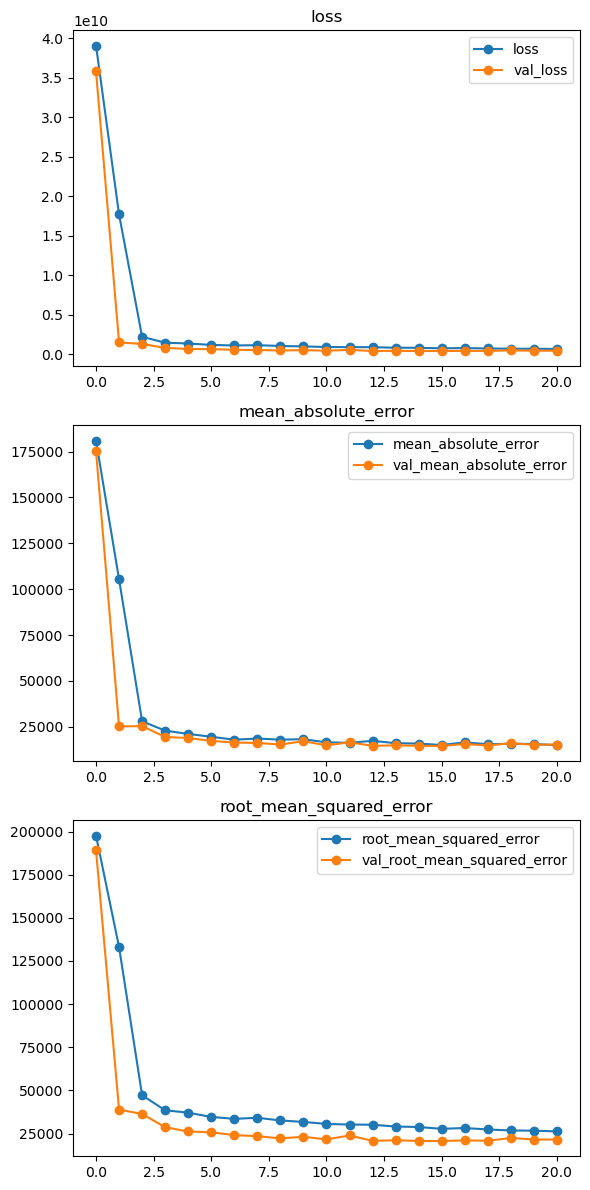

In [135]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
history4 = model4.fit(X_train_tf, y_train,
                        validation_split = .2,
                        epochs=500,
                        verbose=0, callbacks = [early_stop])
plot_history(history4);

In [136]:
y_pred4 = model4.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred4))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred4)}')
print(f'final R2: {r2_score(y_test, y_pred4)}')

12/12 [==============================] - 0s 2ms/step
final RMSE: 29180.132224069992
final MAE: 18291.550888270547
final R2: 0.8784521695970189


**This final model is the best, with an R2 of .8784**